## Апанчёнок Александр  
### 8 группа, ТВиМС  
### Отчёт по лабораторной работе 5  

**Тема:** Классификация на основе логит-модели множественного выбора  
**Дата:** 28.11.2025

<div align="center">
  <h2>Содержание</h2>
</div>

1. 1. Загрузка данных и формирование классов кредитоспособности  
2. 2. Логит-модель множественного выбора: переклассификация всей выборки  
3. 3. Логит-модель множественного выбора: «экзамен» на отложенной выборке  
4. 4. Сравнение результатов логит-модели и дискриминантного анализа  
5. 5. Визуализация результатов  
6. 6. Итоговые выводы  


# 1. Загрузка данных и формирование классов кредитоспособности

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

file = pd.read_csv('../data/Annual 2005-2011.csv')
display(file.head(10))

,empl_num,k1,k2,k3,k4,k5,k6,k7,k8,k9,...,k12,k13,k14,k15,k16,k17,k18,k19,k20,year
0,6095.0,0.942380,0.060563,0.678302,-0.161531,0.202055,0.165019,0.399033,0.799019,5.426569,...,1.082798,0.655937,4.454819,3.975687,0.892446,1007.536232,0.076738,0.055049,0.034904,5.0
1,255.0,1.980494,0.274382,0.916775,0.624425,0.089377,0.220648,0.000000,0.933519,14.041958,...,1.123828,0.705951,10.618881,12.295547,1.157895,357.294118,0.116068,0.059740,0.025647,5.0
2,114.0,0.374160,0.001494,0.085138,-1.504990,0.235739,0.508929,0.888889,0.779049,5.017007,...,1.185374,0.123415,0.794785,6.258929,7.875000,36.894737,-0.584879,0.010563,0.000000,5.0
3,365.0,7.859079,0.831978,2.449864,0.875862,0.059439,0.030030,0.011111,0.942010,16.244444,...,1.309449,2.804607,48.363889,26.142643,0.540541,33.676983,0.171731,0.496295,0.312415,5.0
4,168.0,1.779376,0.005596,0.883293,0.527853,0.135491,0.886686,0.489796,0.887341,10.558673,...,0.994832,0.473041,5.628827,3.125354,0.555241,19.103896,0.064809,0.025726,0.011839,5.0
5,6969.0,4.200293,1.310167,2.355742,0.767058,0.067142,0.043515,0.001988,0.934306,14.222452,...,1.081892,0.958338,14.588270,13.651105,0.935759,84.654633,0.164268,0.140701,0.098621,5.0
6,1754.0,0.835976,0.008003,0.182230,-0.200464,0.488237,0.427889,0.090158,0.516995,2.298864,...,1.058383,0.989701,4.400794,9.688993,2.201647,6.725695,0.041624,0.035402,0.043877,5.0
7,146.0,4.096916,1.193833,1.823789,0.683871,0.036512,0.321678,0.271889,0.964689,37.013825,...,1.015167,0.519457,19.930876,30.244755,1.517483,22.763158,0.084162,0.037833,0.017057,5.0
8,1674.0,2.194307,0.112153,0.740924,0.554451,0.193730,0.023384,0.078174,0.810724,5.873536,...,1.001019,1.829401,13.253646,14.566474,1.099054,19.493671,0.060137,0.117208,0.091945,5.0
9,2455.0,1.215800,0.063003,0.413992,0.089936,0.341383,0.057987,0.041190,0.660346,4.521441,...,1.017691,1.188855,8.140185,10.115851,1.242705,27.631543,0.102509,0.088303,0.062603,5.0


Выделим финансовые коэффициенты (k1, k2, …), удалим наблюдения с пропусками и проведём кластеризацию методом k-средних, как на предыдущей лабораторной работе. Кластеры будем трактовать как классы кредитоспособности.

In [2]:
numeric = file.select_dtypes(include=[np.number]).copy()
financial_cols = [c for c in numeric.columns if c.startswith('k')]
data_fin = numeric[financial_cols].dropna()
data_fin.shape

(2695, 20)

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_fin.values)

k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

classes_df = pd.DataFrame(index=data_fin.index)
classes_df['class'] = cluster_labels
classes_df['class'].value_counts().sort_index()

class
0     779
1     225
2     670
3    1021
Name: count, dtype: int64

Далее переменная `class` используется как целевая при построении логит-модели и дискриминантного анализа.

# 2. Логит-модель множественного выбора: переклассификация всей выборки

Построим многоклассовую логит-модель (многомерную логистическую регрессию) с функцией потерь для всех четырёх классов и оценим качество переклассификации, когда обучающая и тестовая выборки совпадают.

In [7]:
X = X_scaled
y = classes_df['class'].values

logit = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
logit.fit(X, y)

y_pred_logit = logit.predict(X)

labels_sorted = np.sort(np.unique(y))
cm_logit_reclass = confusion_matrix(y, y_pred_logit, labels=labels_sorted)
cm_logit_reclass

array([[ 774,    0,    0,    5],
       [   0,  221,    3,    1],
       [   2,    2,  663,    3],
       [   2,    0,    2, 1017]])

In [8]:
total = cm_logit_reclass.sum()
correct = np.trace(cm_logit_reclass)
overall_error_logit_reclass = 1 - correct / total

class_errors_logit_reclass = {}
for i, label in enumerate(labels_sorted):
    row_sum = cm_logit_reclass[i].sum()
    err = 1 - cm_logit_reclass[i, i] / row_sum
    class_errors_logit_reclass[label] = err

reclass_logit_df = pd.DataFrame({
    'Класс': labels_sorted,
    'Условная вероятность ошибки (логит, переклассификация)': [class_errors_logit_reclass[l] for l in labels_sorted]
})
reclass_logit_df, overall_error_logit_reclass

(   Класс  Условная вероятность ошибки (логит, переклассификация)
 0      0                                                0.006418
 1      1                                                0.017778
 2      2                                                0.010448
 3      3                                                0.003918,
 np.float64(0.007421150278293154))

Получены условные вероятности ошибок по классам и общая безусловная вероятность ошибки классификации логит-модели на исходной выборке.

# 3. Логит-модель множественного выбора: «экзамен» на отложенной выборке

Сформируем экзаменационную выборку: из каждого класса случайным образом исключим по 10% наблюдений. Модель обучим на оставшихся 90% и оценим качество прогноза для отложенных данных.

In [10]:
data_for_models = pd.DataFrame(X, columns=financial_cols, index=data_fin.index)
data_for_models['class'] = y

test_idx = (
    data_for_models.groupby('class', group_keys=False)
    .apply(lambda g: g.sample(frac=0.1, random_state=42))
).index

train_idx = data_for_models.index.difference(test_idx)

X_train = data_for_models.loc[train_idx, financial_cols].values
y_train = data_for_models.loc[train_idx, 'class'].values
X_test = data_for_models.loc[test_idx, financial_cols].values
y_test = data_for_models.loc[test_idx, 'class'].values

X_train.shape, X_test.shape

C:\Temp\ipykernel_12264\414655698.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=0.1, random_state=42))


((2426, 20), (269, 20))

In [12]:
logit_exam = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
logit_exam.fit(X_train, y_train)

y_test_pred_logit = logit_exam.predict(X_test)

cm_logit_exam = confusion_matrix(y_test, y_test_pred_logit, labels=labels_sorted)
cm_logit_exam

array([[ 77,   0,   0,   1],
       [  0,  22,   0,   0],
       [  0,   1,  66,   0],
       [  0,   0,   2, 100]])

In [13]:
total_exam = cm_logit_exam.sum()
correct_exam = np.trace(cm_logit_exam)
overall_error_logit_exam = 1 - correct_exam / total_exam

class_errors_logit_exam = {}
for i, label in enumerate(labels_sorted):
    row_sum = cm_logit_exam[i].sum()
    err = 1 - cm_logit_exam[i, i] / row_sum
    class_errors_logit_exam[label] = err

exam_logit_df = pd.DataFrame({
    'Класс': labels_sorted,
    'Условная вероятность ошибки (логит, экзамен)': [class_errors_logit_exam[l] for l in labels_sorted]
})
exam_logit_df, overall_error_logit_exam

(   Класс  Условная вероятность ошибки (логит, экзамен)
 0      0                                      0.012821
 1      1                                      0.000000
 2      2                                      0.014925
 3      3                                      0.019608,
 np.float64(0.014869888475836479))

Значения условных и безусловной вероятностей ошибок характеризуют качество прогнозирования класса кредитоспособности на новых наблюдениях с помощью логит-модели.

# 4. Сравнение результатов логит-модели и дискриминантного анализа

Для сопоставления качества логит-модели построим линейный дискриминантный анализ на тех же данных и с тем же разбиением на обучающую и экзаменационную выборки.

In [14]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
y_pred_lda = lda.predict(X)

cm_lda_reclass = confusion_matrix(y, y_pred_lda, labels=labels_sorted)
cm_lda_reclass

array([[711,   0,  13,  55],
       [  0, 179,  15,  31],
       [ 31,   0, 573,  66],
       [ 17,   0,   9, 995]])

In [15]:
total_lda = cm_lda_reclass.sum()
correct_lda = np.trace(cm_lda_reclass)
overall_error_lda_reclass = 1 - correct_lda / total_lda

class_errors_lda_reclass = {}
for i, label in enumerate(labels_sorted):
    row_sum = cm_lda_reclass[i].sum()
    err = 1 - cm_lda_reclass[i, i] / row_sum
    class_errors_lda_reclass[label] = err

reclass_lda_df = pd.DataFrame({
    'Класс': labels_sorted,
    'Условная вероятность ошибки (ЛДА, переклассификация)': [class_errors_lda_reclass[l] for l in labels_sorted]
})
reclass_lda_df, overall_error_lda_reclass

(   Класс  Условная вероятность ошибки (ЛДА, переклассификация)
 0      0                                              0.087291
 1      1                                              0.204444
 2      2                                              0.144776
 3      3                                              0.025465,
 np.float64(0.0879406307977737))

In [16]:
lda_exam = LinearDiscriminantAnalysis()
lda_exam.fit(X_train, y_train)
y_test_pred_lda = lda_exam.predict(X_test)

cm_lda_exam = confusion_matrix(y_test, y_test_pred_lda, labels=labels_sorted)
cm_lda_exam

array([[73,  1,  0,  4],
       [ 0, 17,  2,  3],
       [ 2,  0, 52, 13],
       [ 3,  0,  0, 99]])

In [17]:
total_lda_exam = cm_lda_exam.sum()
correct_lda_exam = np.trace(cm_lda_exam)
overall_error_lda_exam = 1 - correct_lda_exam / total_lda_exam

class_errors_lda_exam = {}
for i, label in enumerate(labels_sorted):
    row_sum = cm_lda_exam[i].sum()
    err = 1 - cm_lda_exam[i, i] / row_sum
    class_errors_lda_exam[label] = err

exam_lda_df = pd.DataFrame({
    'Класс': labels_sorted,
    'Условная вероятность ошибки (ЛДА, экзамен)': [class_errors_lda_exam[l] for l in labels_sorted]
})
exam_lda_df, overall_error_lda_exam

(   Класс  Условная вероятность ошибки (ЛДА, экзамен)
 0      0                                    0.064103
 1      1                                    0.227273
 2      2                                    0.223881
 3      3                                    0.029412,
 np.float64(0.10408921933085502))

In [18]:
compare_reclass = reclass_logit_df.set_index('Класс').join(
    reclass_lda_df.set_index('Класс'),
    how='inner'
)
compare_reclass

,"Условная вероятность ошибки (логит, переклассификация)","Условная вероятность ошибки (ЛДА, переклассификация)"
Класс,,
0,0.006418,0.087291
1,0.017778,0.204444
2,0.010448,0.144776
3,0.003918,0.025465


In [19]:
compare_exam = exam_logit_df.set_index('Класс').join(
    exam_lda_df.set_index('Класс'),
    how='inner'
)
compare_exam

,"Условная вероятность ошибки (логит, экзамен)","Условная вероятность ошибки (ЛДА, экзамен)"
Класс,,
0,0.012821,0.064103
1,0.000000,0.227273
2,0.014925,0.223881
3,0.019608,0.029412


По таблицам видно, как меняются условные вероятности ошибок для отдельных классов при использовании логит-модели и линейного дискриминантного анализа, как в режиме переклассификации, так и в режиме экзамена.

# 5. Визуализация результатов

Для наглядного сравнения отобразим условные вероятности ошибок по классам для двух методов.

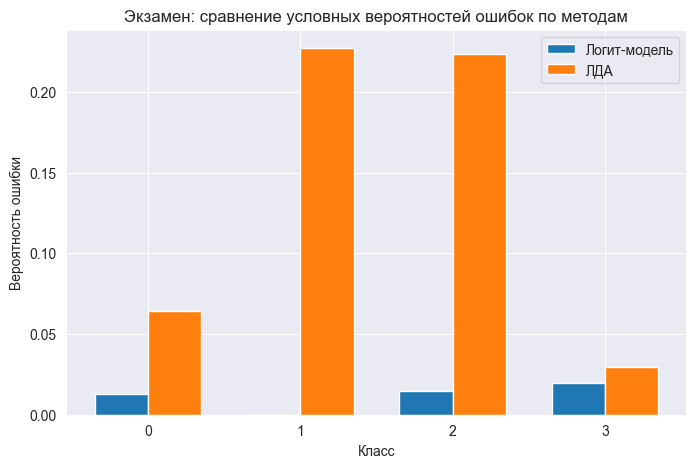

In [20]:
plt.figure(figsize=(8, 5))
x = np.arange(len(labels_sorted))
width = 0.35

plt.bar(x - width/2, compare_exam['Условная вероятность ошибки (логит, экзамен)'], width, label='Логит-модель')
plt.bar(x + width/2, compare_exam['Условная вероятность ошибки (ЛДА, экзамен)'], width, label='ЛДА')

plt.xticks(x, labels_sorted)
plt.xlabel('Класс')
plt.ylabel('Вероятность ошибки')
plt.title('Экзамен: сравнение условных вероятностей ошибок по методам')
plt.legend()
plt.show()


# **Вывод по графику «Экзамен»**

При проверке на отложенной выборке («экзамен»):

-   **Логит-модель показала значительно меньшие условные вероятности ошибок** по всем классам.
    
-   **ЛДА ошибается существенно чаще**, особенно в классах **1 и 2**, где ошибки превышают **0.20**, тогда как логит остаётся в пределах **~0.01–0.02**.
    
-   Для классов **0 и 3** ЛДА также даёт ошибки выше логит-модели.
    

**Итог:** на новых наблюдениях логит-модель демонстрирует **гораздо более устойчивое и точное прогнозирование**, чем ЛДА.

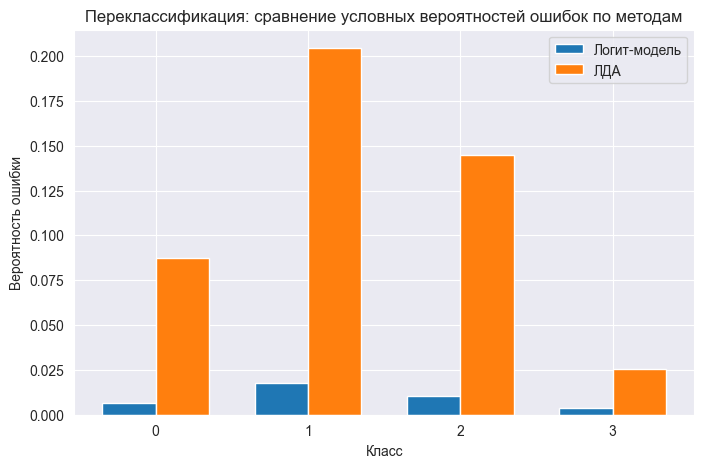

In [21]:
plt.figure(figsize=(8, 5))
x = np.arange(len(labels_sorted))
width = 0.35

plt.bar(x - width/2, compare_reclass['Условная вероятность ошибки (логит, переклассификация)'], width, label='Логит-модель')
plt.bar(x + width/2, compare_reclass['Условная вероятность ошибки (ЛДА, переклассификация)'], width, label='ЛДА')

plt.xticks(x, labels_sorted)
plt.xlabel('Класс')
plt.ylabel('Вероятность ошибки')
plt.title('Переклассификация: сравнение условных вероятностей ошибок по методам')
plt.legend()
plt.show()


# **Вывод по графику «Переклассификация»**

При переклассификации (когда обучаем и тестируем на одних и тех же данных):

-   **Логит-модель снова показывает меньшие ошибки**, чем ЛДА, по всем классам.
    
-   ЛДА особенно плохо работает в классах **1 и 2**, где ошибка достигает **~0.20**, тогда как логит-модель остаётся в районе **0.01–0.02**.
    
-   В классах **0 и 3** логит-модель также превосходит ЛДА по точности.
    

**Итог:** даже в режиме переклассификации логит-модель оказывается **существенно точнее** ЛДА.

# 6. Итоговые выводы

В ходе лабораторной работы были решены следующие задачи:

1. На основе кластерного анализа в пространстве финансовых коэффициентов сформированы классы кредитоспособности предприятий.  
2. Построена логит-модель множественного выбора, позволяющая прогнозировать класс кредитоспособности по значениям финансовых коэффициентов. Оценено качество переклассификации и «экзамена» на отложенной выборке, получены условные и безусловные вероятности ошибок.  
3. Для тех же данных и разбиения выборки построен линейный дискриминантный анализ. Выполнено сравнение вероятностей ошибок логит-модели и дискриминантного анализа.  
4. Графическое сравнение показало, для каких классов и в каких режимах логит-модель и ЛДА дают более точные прогнозы.  

В целом логит-модель множественного выбора демонстрирует сопоставимую точность с дискриминантным анализом и может использоваться как альтернатива для многоклассовой классификации уровня кредитоспособности клиентов, обеспечивая при этом естественную вероятностную интерпретацию результатов.